**Names** Safyre Anderson, Howard Wen , Vamsi Sakhamuri

**Emails** safyre@berkeley.edu, howard.wen1@gmail.com, vamsi@ischool.berkeley.edu 

**Time of Initial Submission:** March 10th, 2016 8am PST

**Section** W261-3, Spring 2016  

**Week** 7 Homework

==========================================================
## ===HW 7.0: Shortest path graph distances (toy networks)===

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

=================================

### Answer:
To begin solving SSSP problems, we need to create some base code for a graph traversal in a distributed environment. Here we test on unweighted undirected and directed graphs. Our MRjob is based off of Dijkstra's Breadth First Search algorithm which--though accurate--is normally run locally and not a good solution for big data. In general, Dijkstra's algorithm for SSSP assigns states to vertices in order to keep track of which vertices have been visited or not. There are 3 states defined: Frontier vertices ('Q') which are on the current level of the traveral, Visited ('V') which have already been traversed and given a shortest path, and Unvisited ('U') which have not yet been traversed. Using these states and knowing the distances or "weights" of the edges, we can accumulate paths and their lengths as we traverse from the source node to all the other nodes in the graph.

Before the first mapper, the nodes are assigned an initial state: The root or "source" node is put on the frontier, and the others are labeled unvisited. These initial states are written to a file graph_with_state.txt which is then streamed to the MRjob Next the mapper will set the the source node to visited and emit it's neighbors after setting them to the frontier state. The rest of the nodes are passed straight through with unvisited status. The frontier node and it's expanded nodes are stored in an intermediate file, 'graph_with_states.txt'. All the nodes are emitted from the mapper to the reducer where most of the SSSP calculation is carried out.  

In the reducer we set a number of flags to perform different functions for the various cases the algorithm will encounter: the first frontier node with it's expanded neighbors, a frontier node with unvisited neighbors, a frontier node with visited neighbors, and of course unvisited nodes (which just get passed through with unvisited state).  In the first case, the first frontier node has already been set to visited by the mapper and the reducer recieves it's expanded neighbors. The reducer then appends the shortest path of the previous node (which is just the source node) to the destination nodes (the neighbors) and sets these new nodes to the frontier. This approach is almost exactly the same for a new frontier node with unvisited neighbors.  In the third case, if a neighbor of a frontier node has been visited, the reducer looks at it's original shortest path, appends the previous node's shortest path to the new node, and compares the lengths of both paths. Whichever path is shorter is kept as the current shortest path to that destination node. Finaly, visited nodes that are not expanded are passed through as is with unvisited status.

These steps are repeated until there are no more nodes on the frontier--all nodes are in the visited state.

In [23]:
%%writefile shortest_path.py
from mrjob.job import MRJob
from mrjob.step import MRJobStep
import sys
import ast

# This MrJob computes the shortest paths from a single source
#     
class shortest_path(MRJob):
    #Adds state and distance information to all the nodes and creates a new file
    def mapper(self, _,line):
        neighbors = []
        edge_info = []
        node = line.split('\t')
        edges = ast.literal_eval(node[1])
        if(node[4]=='Q'):   ##This node is in the frontier, will be expanded
            edge_info = node[1:-1]
            edge_info.append("V")
            yield node[0],edge_info
            for k in edges.keys():
                if(k!='NULL'):
                    neighbors.append([k,edges[k]])
                
            for n in neighbors:
                if(node[3]==' '):
                    path = node[0]
                else:
                    path = node[3]+","+node[0]
                    
                yield n[0],[{'NULL':'NULL'},float(node[2])+1,path,'Q']
        else:
            yield node[0],node[1:]
                  
    def reducer_init(self):
        filename = self.options.pathName+"graph_with_state.txt"
        open(filename,"w").close()
        filenamed = self.options.pathName+"debug.txt"
        open(filenamed,"a+").close()
   
    def reducer(self,key,line):
        filenamed = self.options.pathName+"debug.txt"
        filename = self.options.pathName+"graph_with_state.txt"
        first = True
        visited = False
        queued = False
        unvisited = False

        for l in line:
            debug = []
            for i in l:
                debug.append(str(i))
            with open(filenamed,'a+') as fd:
                fd.writelines(key + "\t" + "\t".join(debug) + "\n")
                    
            if(l[3]==u'Q'):
                if(first==True):
                    shortest_dist = (l[1])
                    first = False
                    shortest_path = l[2]
                else:
                    if(float(shortest_dist)>=float(l[1])):
                        shortest_dist = (l[1])
                        shortest_path = l[2]
                queued = True
            if(l[3]==u'U'):
                edges = str(l[0])
                unvisited = True
                
            if(l[3]==u'V'):
                shortest_dist_V = (l[1])
                shortest_path_V = l[2]
                edges = str(l[0])
                visited = True
            
        if(visited==True):
            if(queued==True):
                if(float(shortest_dist_V) >= float(shortest_dist)):
                    shortest_dist_m = shortest_dist
                    shortest_path_m = shortest_path
                else:
                    shortest_dist_m = shortest_dist_V
                    shortest_path_m = shortest_path_V
            else:
                shortest_dist_m = shortest_dist_V
                shortest_path_m = shortest_path_V
            new_node_info = [edges,str(shortest_dist_m),str(shortest_path_m),'V']
        
        elif(unvisited==True):
            if(queued==True):
                shortest_dist_m = shortest_dist
                shortest_path_m = shortest_path
                new_node_info = [edges,str(shortest_dist_m),str(shortest_path_m),'Q']
            else:
                new_node_info = [str(l[0]),str(l[1]),str(l[2]),'U']               
        
        else:
            new_node_info = [str(l[0]),str(l[1]),str(l[2]),l[3]]

        with open(filename,'a+') as fw:
            fw.writelines(key + "\t" + "\t".join(new_node_info) + "\n")
        yield key,new_node_info
 
    def reducer_final(self):
        filenamed = self.options.pathName+"debug.txt"
        with open(filenamed,"a+") as fd:
            fd.write("Done with an iteration \n")
        
    def configure_options(self):
        super(shortest_path, self).configure_options()
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermedateResults.txt is stored')
    
    def steps(self):
        return [MRJobStep(mapper=self.mapper,reducer_init=self.reducer_init,reducer=self.reducer,
                        reducer_final=self.reducer_final)] 
    
if __name__ == '__main__':
    shortest_path.run()

Overwriting shortest_path.py


In [24]:
!rm graph_with_state.txt

In [25]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from shortest_path import shortest_path
import sys

first = True

fa = 'directed_toy.txt'
fb = 'graph_with_state.txt'

#Transforming the directed_toy.txt to included state,distance,path information
with open(fa, 'r') as fr:
    for f in fr:
        adj_list = []
        adjl = f.strip().split('\t')
        if(first==True):
            adj_list.append(adjl[0]) #Node
            adj_list.append(adjl[1]) #Edges and Weights
            adj_list.append(str(0))  #Shortest Distance
            adj_list.append(' ')    #Shortest Path          
            adj_list.append('Q')     #state
            first=False
        else:
            adj_list.append(adjl[0])         #Node
            adj_list.append(adjl[1])         #Edges and Weights
            adj_list.append(str(sys.maxint)) #Shortest Distance
            adj_list.append(' ')            #Shortest Path
            adj_list.append('U')             #state
        
        with open(fb,'a+') as fw:
            fw.writelines('\t'.join(adj_list)+'\n')

mr_job = shortest_path(args=[fb,'--pathName','/Users/Vamsi/Documents/W261/hw7/']) 

i = 1
while(1):
    print "\n","iteration ",i,"\n"
    unvisited_nodes = 0
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            print key,value
            if(value[3]!=u'V'):
                unvisited_nodes = unvisited_nodes + 1
            
    if(unvisited_nodes==0):
        break
    i +=1

print "Done- All nodes have been visited"
            


iteration  1 

1

 [u"{'2': 1, '6': 1}", u'0', u' ', u'V']
2 [u"{'1': 1, '3': 1, '4': 1}", u'1.0', u'1', u'Q']
3 [u"{'2': 1, '4': 1}", u'9223372036854775807', u' ', u'U']
4 [u"{'2': 1, '5': 1}", u'9223372036854775807', u' ', u'U']
5 [u"{'1': 1, '2': 1, '4': 1}", u'9223372036854775807', u' ', u'U']
6 [u"{u'NULL': u'NULL'}", u'1.0', u'1', u'Q']

iteration  2 

1

 [u"{'2': 1, '6': 1}", u'0', u' ', u'V']
2 [u"{'1': 1, '3': 1, '4': 1}", u'1.0', u'1', u'V']
3 [u"{'2': 1, '4': 1}", u'2.0', u'1,2', u'Q']
4 [u"{'2': 1, '5': 1}", u'2.0', u'1,2', u'Q']
5 [u"{'1': 1, '2': 1, '4': 1}", u'9223372036854775807', u' ', u'U']
6 [u"{u'NULL': u'NULL'}", u'1.0', u'1', u'V']

iteration  3 

1

 [u"{'2': 1, '6': 1}", u'0', u' ', u'V']
2 [u"{'1': 1, '3': 1, '4': 1}", u'1.0', u'1', u'V']
3 [u"{'2': 1, '4': 1}", u'2.0', u'1,2', u'V']
4 [u"{'2': 1, '5': 1}", u'2.0', u'1,2', u'V']
5 [u"{'1': 1, '2': 1, '4': 1}", u'3.0', u'1,2,4', u'Q']
6 [u"{u'NULL': u'NULL'}", u'1.0', u'1', u'V']

iteration  4 

1 [u"{'2': 1, '6': 1}", u'0', u' ', u'V']
2 [u"{'1': 1, '3': 1, '4': 1}", u'1.0', u'1', u'V']
3 [u"{'2': 1, '4': 1}", u'2.0', u'1,2', u'V']
4 [u"{'2': 1, '5': 1}", u'2.0', u'1,2', u'V']
5 [u"{'1': 1, '2': 1, '4': 1}", u'3.0', u'1,2,4', u'V']
6 [u"{u'NULL': u'NULL'}", u'1.0', u'1', u'V']
Done- All nodes have been visited


**Attention: The output above is in the following format:**

`Node [Edges,Shortest Distance,Shortest Path,State]`


In [26]:
!rm graph_with_state.txt

In [27]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from shortest_path import shortest_path
import sys

first = True

fa = 'undirected_toy.txt'
fb = 'graph_with_state.txt'

#Transforming the directed_toy.txt to included state,distance,path information
with open(fa, 'r') as fr:
    for f in fr:
        adj_list = []
        adjl = f.strip().split('\t')
        if(first==True):
            adj_list.append(adjl[0]) #Node
            adj_list.append(adjl[1]) #Edges and Weights
            adj_list.append(str(0))  #Shortest Distance
            adj_list.append(' ')    #Shortest Path          
            adj_list.append('Q')     #state
            first=False
        else:
            adj_list.append(adjl[0])         #Node
            adj_list.append(adjl[1])         #Edges and Weights
            adj_list.append(str(sys.maxint)) #Shortest Distance
            adj_list.append(' ')            #Shortest Path
            adj_list.append('U')             #state
        
        with open(fb,'a+') as fw:
            fw.writelines('\t'.join(adj_list)+'\n')

mr_job = shortest_path(args=[fb,'--pathName','/Users/Vamsi/Documents/W261/hw7/']) 

i = 1
while(1):
    print "\n","iteration ",i,"\n"
    unvisited_nodes = 0
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            print key,value
            if(value[3]!=u'V'):
                unvisited_nodes = unvisited_nodes + 1
            
    if(unvisited_nodes==0):
        break
    i +=1

print "Done- All nodes have been visited"


iteration  1 

1

 [u"{'2': 1,'5': 1}", u'0', u' ', u'V']
2 [u"{'1': 1,'3': 1,'4': 1,'5': 1}", u'1.0', u'1', u'Q']
3 [u"{'2': 1, '4': 1}", u'9223372036854775807', u' ', u'U']
4 [u"{'2': 1,'3': 1,'5': 1}", u'9223372036854775807', u' ', u'U']
5 [u"{'1': 1, '2': 1, '4': 1}", u'1.0', u'1', u'Q']

iteration  2 

1

 [u"{'2': 1,'5': 1}", u'0', u' ', u'V']
2 [u"{'1': 1,'3': 1,'4': 1,'5': 1}", u'1.0', u'1', u'V']
3 [u"{'2': 1, '4': 1}", u'2.0', u'1,2', u'Q']
4 [u"{'2': 1,'3': 1,'5': 1}", u'2.0', u'1,5', u'Q']
5 [u"{'1': 1, '2': 1, '4': 1}", u'1.0', u'1', u'V']

iteration  3 

1 [u"{'2': 1,'5': 1}", u'0', u' ', u'V']
2 [u"{'1': 1,'3': 1,'4': 1,'5': 1}", u'1.0', u'1', u'V']
3 [u"{'2': 1, '4': 1}", u'2.0', u'1,2', u'V']
4 [u"{'2': 1,'3': 1,'5': 1}", u'2.0', u'1,5', u'V']
5 [u"{'1': 1, '2': 1, '4': 1}", u'1.0', u'1', u'V']
Done- All nodes have been visited


**Attention: The output above is in the following format:**

`Node [Edges,Shortest Distance,Shortest Path,State]`


## =================================
## ==Main dataset 1: NLTK synonyms==

In the next part of this assignment you will explore a network derived from
the NLTK synonym database used for evaluation in HW 5. At a high level, this
network is undirected, defined so that there exists link between two nodes/words 
if the pair or words are a synonym. These data may be found at the location:

s3://ucb-mids-mls-networks/synNet/synNet.txt  
s3://ucb-mids-mls-networks/synNet/indices.txt
On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


## =======================================================
## ===HW 7.1: Exploratory data analysis (NLTK synonyms)===

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes,  
number links,  
or the average degree (i.e., the average number of links per node),  
etc...  

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [28]:
%%writefile nltk_stats.py
from mrjob.job import MRJob
from mrjob.step import MRJobStep
import sys
import ast

# This MrJob computes the shortest paths from a single source
#     Mapper: calculate partial gradient for each example  
#     
class nltk_stats(MRJob):
    # run before the mapper processes any input. 
    #Adds state and distance information to all the nodes and creates a new file
                
    # Calculate partial gradient for each example 
    def mapper(self, _,line):
        total = line.split('\t')
        node = total[0]
        edge = total[1]
        edges = ast.literal_eval(edge)       
        yield node,len(edges)
    
    def reducer(self,key,value):
        for v in value:
            yield key,v
        
    def steps(self):
        return [MRJobStep(mapper=self.mapper,reducer=self.reducer)] 
    
if __name__ == '__main__':
    nltk_stats.run()

Overwriting nltk_stats.py


In [29]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from nltk_stats import nltk_stats
import sys

mr_job = nltk_stats(args=['synNet.txt']) 
#mr_job = nltk_stats(args=['s3://hw7-ml261/synNet.txt','-r','emr'])

total_nodes = 0
total_links = 0
num_links_acc = []
with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        node,num_links =  mr_job.parse_output_line(line)
        total_nodes = total_nodes+1
        total_links = total_links+int(num_links)
        num_links_acc.append([float(node),num_links])

avg_degree = total_links/float(total_nodes)

print "Total number of nodes in the graph is : ",total_nodes
print "Average degree (total_links/total_nodes) of the graph is : ",avg_degree
print "Total number of links/edges in the graph are : ",total_links/2

Total number of nodes in the graph is :  8271
Average degree (total_links/total_nodes) of the graph is :  7.39136742836
Total number of links/edges in the graph are :  30567


In [30]:
%matplotlib inline

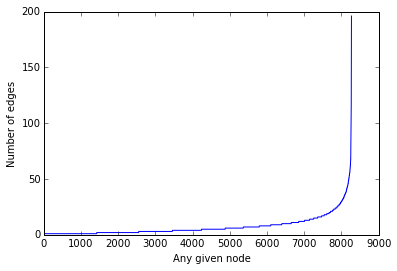

In [31]:
#Plot
import numpy as np
import matplotlib.pyplot as plt

num_links_acc = np.array(num_links_acc)
sorted_link_count = np.sort(num_links_acc[:,1])
plt.plot(sorted_link_count)
plt.ylabel("Number of edges")
plt.xlabel("Any given node")
plt.show()

Yes, the degree distribution (number of edges) follows a square law.

### ===========================================================
### ===HW 7.2: Shortest path graph distances (NLTK synonyms)===

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [32]:
%%writefile shortest_path_nltk.py
from mrjob.job import MRJob
from mrjob.step import MRJobStep
import sys
import ast

# This MrJob computes the shortest paths from a single source
#     Mapper: calculate partial gradient for each example  
#     
class shortest_path_nltk(MRJob):
    # run before the mapper processes any input. 
    #Adds state and distance information to all the nodes and creates a new file
                
    # Calculate partial gradient for each example 
    def mapper(self, _,line):
        neighbors = []
        edge_info = []
        node = line.split('\t')
        edges = ast.literal_eval(node[1])
        if(node[4]=='Q'):   ##This node is in the frontier, will be expanded
            edge_info = node[1:-1]
            edge_info.append("V")
            yield node[0],edge_info
            for k in edges.keys():
                if(k!='NULL'):
                    neighbors.append([k,edges[k]])
                
            for n in neighbors:
                if(node[3]==' '):
                    path = node[0]
                else:
                    path = node[3]+","+node[0]
                    
                yield n[0],[{'NULL':'NULL'},float(node[2])+1,path,'Q']
        else:
            yield node[0],node[1:]
                  
    def reducer_init(self):
        filename = self.options.pathName+"graph_with_state.txt"
        open(filename,"w").close()
        filenamed = self.options.pathName+"debug.txt"
        open(filenamed,"w").close()
   
    def reducer(self,key,line):
        filenamed = self.options.pathName+"debug.txt"
        filename = self.options.pathName+"graph_with_state.txt"
        first = True
        visited = False
        queued = False
        unvisited = False

        for l in line:
            debug = []
            for i in l:
                debug.append(str(i))
            with open(filenamed,'a+') as fd:
                fd.writelines(key + "\t" + "\t".join(debug) + "\n")
                    
            if(l[3]==u'Q'):
                if(first==True):
                    shortest_dist = (l[1])
                    first = False
                    shortest_path = l[2]
                else:
                    if(float(shortest_dist)>=float(l[1])):
                        shortest_dist = (l[1])
                        shortest_path = l[2]
                queued = True
            if(l[3]==u'U'):
                edges = str(l[0])
                unvisited = True
                
            if(l[3]==u'V'):
                shortest_dist_V = (l[1])
                shortest_path_V = l[2]
                edges = str(l[0])
                visited = True
            
        if(visited==True):
            if(queued==True):
                if(float(shortest_dist_V) >= float(shortest_dist)):
                    shortest_dist_m = shortest_dist
                    shortest_path_m = shortest_path
                else:
                    shortest_dist_m = shortest_dist_V
                    shortest_path_m = shortest_path_V
            else:
                shortest_dist_m = shortest_dist_V
                shortest_path_m = shortest_path_V
            new_node_info = [edges,str(shortest_dist_m),str(shortest_path_m),'V']
        
        elif(unvisited==True):
            if(queued==True):
                shortest_dist_m = shortest_dist
                shortest_path_m = shortest_path
                new_node_info = [edges,str(shortest_dist_m),str(shortest_path_m),'Q']
            else:
                new_node_info = [str(l[0]),str(l[1]),str(l[2]),'U']               
        
        else:
            new_node_info = [str(l[0]),str(l[1]),str(l[2]),l[3]]

        with open(filename,'a+') as fw:
            fw.writelines(key + "\t" + "\t".join(new_node_info) + "\n")
        yield key,new_node_info
 
    def reducer_final(self):
        filenamed = self.options.pathName+"debug.txt"
        with open(filenamed,"a+") as fd:
            fd.write("Done with an iteration \n")
        
    def configure_options(self):
        super(shortest_path_nltk, self).configure_options()
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermedateResults.txt is stored')
    
    def steps(self):
        return [MRJobStep(mapper=self.mapper,reducer_init=self.reducer_init,reducer=self.reducer,
                        reducer_final=self.reducer_final)] 
    
if __name__ == '__main__':
    shortest_path_nltk.run()

Overwriting shortest_path_nltk.py


In [33]:
!rm graph_with_state.txt

In [34]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from shortest_path_nltk import shortest_path_nltk
import sys

fa = 'synNet.txt'
fb = 'graph_with_state.txt'

#Transforming the directed_toy.txt to included state,distance,path information
with open(fa, 'r') as fr:
    for f in fr:
        adj_list = []
        adjl = f.strip().split('\t')
        if(adjl[0]==u'7827'):
            adj_list.append(adjl[0]) #Node
            adj_list.append(adjl[1]) #Edges and Weights
            adj_list.append(str(0))  #Shortest Distance
            adj_list.append(' ')    #Shortest Path          
            adj_list.append('Q')     #state
            first=False
        else:
            adj_list.append(adjl[0])         #Node
            adj_list.append(adjl[1])         #Edges and Weights
            adj_list.append(str(sys.maxint)) #Shortest Distance
            adj_list.append(' ')            #Shortest Path
            adj_list.append('U')             #state
        
        with open(fb,'a+') as fw:
            fw.writelines('\t'.join(adj_list)+'\n')

mr_job = shortest_path_nltk(args=[fb,'--pathName','/Users/Vamsi/Documents/W261/hw7/']) 

i = 1
while(1):
    print "\n","iteration ",i,"\n"
    unvisited_nodes = 0
    queued_nodes = 0
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            #Only print the ending node of interest 536
            if(key==u'536'):
                print key,value
            if(value[3]!=u'V'):
                unvisited_nodes = unvisited_nodes + 1
            if(value[3]==u'Q'):
                queued_nodes = queued_nodes + 1
                
#Break if no nodes to visit or if there are no queued nodes (which indicates unreachable nodes from starting node)                                                                                    
    if(unvisited_nodes==0 or (unvisited_nodes!=0 and queued_nodes==0)):   
        break
    i +=1

print "Done- All nodes have been visited"


iteration  1 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '26

iteration  2 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '265

iteration  3 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '265

iteration  4 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '265

iteration  5 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '265

iteration  6 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '265

iteration  7 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '265

iteration  8 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '265

iteration  9 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '265

iteration  10 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '26

iteration  11 

536 [u"{'531': 1, '653': 1, '1162': 1, '1195': 1, '1209': 1, '1554': 1, '1647': 1, '1668': 1, '1685': 1, '1801': 1, '1810': 1, '1811': 1, '2246': 1, '2256': 1, '2439': 1, '3241': 1, '3471': 1, '3478': 1, '3483': 1, '2247': 1, '3647': 1, '3648': 1, '532': 1, '533': 1, '5208': 1, '5209': 1, '616': 1, '5364': 1, '5281': 1, '5365': 1, '2160': 1, '4651': 1, '4652': 1, '215': 1, '4316': 1, '4317': 1, '534': 1, '5210': 1, '5211': 1, '2248': 1, '6000': 1, '2249': 1, '6056': 1, '6057': 1, '6058': 1, '3760': 1, '64': 1, '1313': 1, '3761': 1, '3310': 1, '631': 1, '3551': 1, '3552': 1, '3553': 1, '3554': 1, '3555': 1, '2250': 1, '5592': 1, '5593': 1, '5594': 1, '404': 1, '3656': 1, '4791': 1, '1199': 1, '6001': 1, '6002': 1, '770': 1, '5911': 1, '5912': 1, '4180': 1, '121': 1, '3737': 1, '3738': 1, '3739': 1, '3992': 1, '657': 1, '3740': 1, '3741': 1, '264': 1, '1688': 1, '3993': 1, '448': 1, '3742': 1, '3743': 1, '3593': 1, '3594': 1, '474': 1, '3595': 1, '3621': 1, '2251': 1, '26

**Attention: The output above is in the following format:**

`Node [Edges,Shortest Distance,Shortest Path,State]`


### =====================================
### ==Main dataset 2: English Wikipedia==

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.
The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt  
Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt  
Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt  

On under the Data Subfolder for HW7 on Dropbox with the same file names

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.


### ===================================================
### ===HW 7.3: Exploratory data analysis (Wikipedia)===

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.


In [35]:
%%writefile wiki_stats.py
from mrjob.job import MRJob
from mrjob.step import MRJobStep
import sys
import ast

# This MrJob computes the shortest paths from a single source
#     Mapper: calculate partial gradient for each example  
#     
class wiki_stats(MRJob):
    # run before the mapper processes any input. 
    #Adds state and distance information to all the nodes and creates a new file
                
    # Calculate partial gradient for each example 
    def mapper(self, _,line):
        total = line.split('\t')
        node = total[0]
        edge = total[1]
        edges = ast.literal_eval(edge)       
        yield node,len(edges)
    
    def reducer(self,key,value):
        for v in value:
            yield key,v
        
    def steps(self):
        return [MRJobStep(mapper=self.mapper,reducer=self.reducer)] 
    
if __name__ == '__main__':
    wiki_stats.run()

Overwriting wiki_stats.py


In [36]:
!python wiki_stats.py directed_toy.txt

using configs in /Users/Vamsi/.mrjob.conf
creating tmp directory /var/folders/83/pm9jkj6j6x701q8n5q42drjr0000gn/T/wiki_stats.Vamsi.20160313.012718.471138

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

MRJobStep has been renamed to MRStep. The old name will be removed in v0.5.0.
writing to /var/folders/83/pm9jkj6j6x701q8n5q42drjr0000gn/T/wiki_stats.Vamsi.20160313.012718.471138/step-0-mapper_part-00000
MRJobStep has been renamed to MRStep. The old name will be removed in v0.5.0.
MRJobStep has been renamed to MRStep. The old name will be removed in v0.5.0.
Counters from step 1:
  (no counters found)
writing to /var/folders/83/pm9jkj6j6x701q8n5q42drjr0000gn/T/wiki_stats.Vamsi.20160313.012718.471138/step-0-mapper-sorted
> sort /var/folders/83/pm9jkj6j6x701q8n5q42drjr0000gn/T/wiki_stats.Vamsi.201

In [10]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from wiki_stats import wiki_stats
import sys

mr_job = wiki_stats(args=['s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt','-r','emr'])

total_nodes = 0
total_links = 0
with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        node,num_links =  mr_job.parse_output_line(line)
        total_nodes = total_nodes+1
        total_links = total_links+int(num_links)

avg_degree = total_links/float(total_nodes)

print "Total number of nodes in the graph is : ",total_nodes
print "Average out-degree (total_links/total_nodes) of the graph is : ",avg_degree
print "Total number of links/edges in the graph are : ",total_links

ERROR:mrjob.emr:Unable to load progress from job tracker
ERROR:mrjob.emr:Unable to load progress from job tracker
ERROR:mrjob.emr:Unable to load progress from job tracker


Total number of nodes in the graph is :  5781290
Average degree (total_links/total_nodes) of the graph is :  24.5817208616
Total number of links/edges in the graph are :  142114057


In [11]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from wiki_stats import wiki_stats
import sys

mr_job = wiki_stats(args=['s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt','-r','emr'])

total_nodes = 0
total_links = 0
with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        node,num_links =  mr_job.parse_output_line(line)
        total_nodes = total_nodes+1
        total_links = total_links+int(num_links)

avg_degree = total_links/float(total_nodes)

print "Total number of nodes in the graph is : ",total_nodes
print "Average in-degree (total_links/total_nodes) of the graph is : ",avg_degree
print "Total number of links/edges in the graph are : ",total_links

ERROR:mrjob.emr:Unable to load progress from job tracker
ERROR:mrjob.emr:Unable to load progress from job tracker
ERROR:mrjob.emr:Unable to load progress from job tracker


Total number of nodes in the graph is :  14216021
Average in-degree (total_links/total_nodes) of the graph is :  9.99675345162
Total number of links/edges in the graph are :  142114057


### =======================================================
### ===HW 7.4: Shortest path graph distances (Wikipedia)===

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output.

Once your code is running, find some other shortest paths and report your results.

In [37]:
%%writefile shortest_path_wiki.py
from mrjob.job import MRJob
from mrjob.step import MRJobStep
import sys
import ast

# This MrJob computes the shortest paths from a single source
#     Mapper: calculate partial gradient for each example  
#     
class shortest_path_wiki(MRJob):
    # run before the mapper processes any input. 
    #Adds state and distance information to all the nodes and creates a new file
                
    # Calculate partial gradient for each example 
    def mapper(self, _,line):
        neighbors = []
        edge_info = []
        node = line.split('\t')
        edges = ast.literal_eval(node[1])
        if(node[4]=='Q'):   ##This node is in the frontier, will be expanded
            edge_info = node[1:-1]
            edge_info.append("V")
            yield node[0],edge_info
            for k in edges.keys():
                if(k!='NULL'):
                    neighbors.append([k,edges[k]])
                
            for n in neighbors:
                if(node[3]==' '):
                    path = node[0]
                else:
                    path = node[3]+","+node[0]
                    
                yield n[0],[{'NULL':'NULL'},float(node[2])+1,path,'Q']
        else:
            yield node[0],node[1:]
                  
    def reducer_init(self):
        filename = self.options.pathName+"graph_with_state.txt"
        open(filename,"w").close()
        filenamed = self.options.pathName+"debug.txt"
        open(filenamed,"w").close()
   
    def reducer(self,key,line):
        filenamed = self.options.pathName+"debug.txt"
        filename = self.options.pathName+"graph_with_state.txt"
        first = True
        visited = False
        queued = False
        unvisited = False

        for l in line:
            debug = []
            for i in l:
                debug.append(str(i))
            with open(filenamed,'a+') as fd:
                fd.writelines(key + "\t" + "\t".join(debug) + "\n")
                    
            if(l[3]==u'Q'):
                if(first==True):
                    shortest_dist = (l[1])
                    first = False
                    shortest_path = l[2]
                else:
                    if(float(shortest_dist)>=float(l[1])):
                        shortest_dist = (l[1])
                        shortest_path = l[2]
                queued = True
            if(l[3]==u'U'):
                edges = str(l[0])
                unvisited = True
                
            if(l[3]==u'V'):
                shortest_dist_V = (l[1])
                shortest_path_V = l[2]
                edges = str(l[0])
                visited = True
            
        if(visited==True):
            if(queued==True):
                if(float(shortest_dist_V) >= float(shortest_dist)):
                    shortest_dist_m = shortest_dist
                    shortest_path_m = shortest_path
                else:
                    shortest_dist_m = shortest_dist_V
                    shortest_path_m = shortest_path_V
            else:
                shortest_dist_m = shortest_dist_V
                shortest_path_m = shortest_path_V
            new_node_info = [edges,str(shortest_dist_m),str(shortest_path_m),'V']
        
        elif(unvisited==True):
            if(queued==True):
                shortest_dist_m = shortest_dist
                shortest_path_m = shortest_path
                new_node_info = [edges,str(shortest_dist_m),str(shortest_path_m),'Q']
            else:
                new_node_info = [str(l[0]),str(l[1]),str(l[2]),'U']               
        
        else:
            new_node_info = [str(l[0]),str(l[1]),str(l[2]),l[3]]

        with open(filename,'a+') as fw:
            fw.writelines(key + "\t" + "\t".join(new_node_info) + "\n")
        yield key,new_node_info
 
    def reducer_final(self):
        filenamed = self.options.pathName+"debug.txt"
        with open(filenamed,"a+") as fd:
            fd.write("Done with an iteration \n")
        
    def configure_options(self):
        super(shortest_path_wiki, self).configure_options()
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermedateResults.txt is stored')
    
    def steps(self):
        return [MRJobStep(mapper=self.mapper,reducer_init=self.reducer_init,reducer=self.reducer,
                        reducer_final=self.reducer_final)] 
    
if __name__ == '__main__':
    shortest_path_wiki.run()

Writing shortest_path_wiki.py


In [ ]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from shortest_path_wiki import shortest_path_wiki
import sys

fb = 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt'

mr_job = shortest_path_nltk(args=['s3://hw7-ml261-test/output/part-00000','--pathName',
                                  's3://hw7-ml261-test/output/part-00000','-r','emr',
                                  '--emr-job-flow-id','j-3K9IEHLMWH49K'])
i = 1
while(1):
    print "\n","iteration ",i,"\n"
    unvisited_nodes = 0
    queued_nodes = 0
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            #Only print the ending node of interest 536
            if(key==u'536'):
                print key,value
            if(value[3]!=u'V'):
                unvisited_nodes = unvisited_nodes + 1
            if(value[3]==u'Q'):
                queued_nodes = queued_nodes + 1
                
#Break if no nodes to visit or if there are no queued nodes (which indicates unreachable nodes from starting node)                                                                                    
    if(unvisited_nodes==0 or (unvisited_nodes!=0 and queued_nodes==0)):   
        break
    i +=1

print "Done- All nodes have been visited"

Our code works on the unit-test performed on the directed_toy.txt dataset, which acts as proof that our code is functional. However, due to problems with iterating our Map-Reduce job on AWS, we were unable to run the code on Wiki dataset.

### ==========================================================================
### ===HW 7.5: Conceptual exercise: Largest single-source network distances===

Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

### Answer:

The parallelized Dijkstra's algorithm has a feature that is a double-edged sword: It traverses all nodes that are in contact with each other. On one hand, this breadth-first traversal can be computationally expensive because it needs to calculate all possible paths from the source to the end node.  On the other hand, because it traverses all possible paths, we can get the shortest and the longest paths simultaneously. Therefore in our implementation, we wouldn't have to make many changes--just one. In our reducer's update step where compare a previously stored path and a new path, we would need to store the path with the greater distance instead of the smaller. The rest of the program could remain the same.

Because the stop condition is the same for both versions of the algorithm, we wouldn't expect a change in the number of iterations, the runtime, or the general system requirements. The number of iterations would still be a function of the number of links between the source and the last node it is indirectly connected to, the system requirements would still need to include a storage volume sufficient to hold the original data (Amazon S3 in most cases), and a cluster that can produce enough reducers to match the number of nodes in the graph.

### ========================================================================================
OPTIONAL
### ===HW 7.6: Computational exercise: Largest single-source network distances (optional)===

Using MRJob, write a code to find the largest graph distance and distance-maximizing nodes from a single-source.
Test your code first on the toy networks and synonyms network to proof its function.
